# Examples of using extra_decorr_vectors 

**N.B.** This notebook has also been used to test the implementation of `extra_decorr_vectors`, so some features are used in ways that do not produce useful results.


#### Help on extra_basis functions from help(Dataset.lmfit_transit)

```

    Arbitrary basis vectors for decorrelation specified by the user, each
    with its own linear coefficient, can be included in the model using
    the extra_decorr_vectors keyword. Use the keyword extra_decorr_vectors
    to specify these detending basis vectors in the following format ...

      extra_decorr_vectors = {'t':t, 'a':{'x':a}, 'b',{'x':b}}

    The times at which the basis vectors are sampled can be specified
    using the key 't'. Times are specfied using the same time scale as
    dataset.lc['time'], i.e. BJD_TDB-dataset.bjd_ref. Each basis vector
    is then provided by the user using a dict with the value of the basis
    function at these times specified as an array-like object provided
    using the key 'x'. If 't' is not provided then the basis functions are
    assumed to be sampled at the same times as dataset.lc['time']. An
    exception is raised if the times specified do not overlap the same
    time range as dataset.lc['time'].

    The array of values provided for each basis vector are used to create
    a linear interpolating function that can be used to evaluate the
    basis function at arbitrary times. By default, the first/last value in
    the array is used to extrapolate to times before/after the input array
    of times. To specify different extrapolated values, use the
    'fill_value' key to specify a value of the fill_value keyword to be
    used in scipy.interpolate.interp1d, e.g.

      extra_decorr_vectors = { 'a':{'x':a, 'fill_value':0},
                            'b':{'x':b, 'fill_value':np.mean(b)},
                            'c':{'x':c, 'fill_value':'extrapolate'} }

    Summary statistics for each basis vector are printed on initialisation
    of FactorModel. It is advisable to use basis vectors with a mean
    value of 0 and with a range or standard deviation of about 1. It is
    also advisable to avoid basis vectors that are strongly correlated
    with one another or other parameters being using for decorrelation.

    By default, the coefficients for each basis vector are labeled in
    plots using the key prefixed by 'dfd'. Alternative labels can be
    specified using the 'label' key, e.g.

      extra_decorr_vectors={'x2':{'x':dx**2,
                            'label':'$d^2f/d(\Delta x)^2$'}}

    Initial values and priors for each linear coefficient can be specified
    in the same way as other parameters used in dataset.lmfit_transit() or
    dataset.lmfit_eclipse() using the 'init' key,  e.g.

      extra_decorr_vectors = { 'a':{'x':a, 'init':(-2,2)},
                               'b':{'x':b, 'init':ufloat(0,1),
                               'c':{'x':c, 'init':0}}
                               
    If not specified, the parameter is initialised using (-1, 1), i.e.
    initial value = 0, min=-1, max=1.

```

In [1]:
%pylab inline
from pycheops import Dataset, PlanetProperties, StarProperties, MultiVisit
from uncertainties import ufloat


Populating the interactive namespace from numpy and matplotlib


## KELT-11b 

In [2]:
dataset=Dataset('CH_PR300024_TG000101_V0200')

Found archive tgzfile /Users/pflm/pycheops/data/CH_PR300024_TG000101_V0200.tgz
 PI name     : Andrea FORTIER
 OBS ID      : 1015981
 Target      : KELT-11b
 Coordinates : 10:46:49.74 -09:23:56.5
 Spec. type  : G9V
 G magnitude : 8.04 +- 0.03


In [3]:
star = StarProperties(dataset.target)
print(star)
Kelt11b = PlanetProperties('KELT-11b', query_dace=False)
print(Kelt11b)    

Identifier : KELT-11b
Coordinates: 10:46:49.74 -09:23:56.5
T_eff :  5470 +/-  35 K   [SWEET-Cat]
log g :  3.74 +/- 0.01    [SWEET-Cat (gaia)]
[M/H] : +0.28 +/- 0.03    [SWEET-Cat]
log rho : -1.16 +/- 0.05  (solar units)
h_1 : 0.716 +/- 0.010     [Stagger]
h_2 : 0.444 +/- 0.050     [Stagger]

Identifier : KELT-11b
T0 : 2458260.1686 +/- 0.0000 BJD       [TEPCat]
P :     4.7362050 +/- 0.0000009 days   [TEPCat]
depth :  2200.0000 +/- 100.0000 ppm         [TEPCat]
width :  0.2974 +/- 0.0100 days            [TEPCat]



#### Compute extra basis functions
Only to illustate the syntax and technicalities of how to define and use the `extra_basis_funcs` option, maybe not a useful or sensible choice.



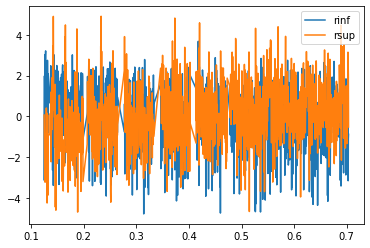

In [4]:
tinf, finf, finferr = dataset.get_lightcurve(aperture='RINF', 
                                        reject_highpoints=False, decontaminate=False, verbose=False)
tdef, fdef, fdeferr = dataset.get_lightcurve(aperture='DEFAULT', 
                                        reject_highpoints=False, decontaminate=False, verbose=False)
tsup, fsup, fsuperr = dataset.get_lightcurve(aperture='RSUP', 
                                        reject_highpoints=False, decontaminate=False, verbose=False)

rinf = finf/fdef
rinf -= np.median(rinf)        
rinf /= np.median(abs(rinf))   # Set range of values to ~1 to coeffiecient =~ size of correction
rinf[abs(rinf) > 5] = 0        # Set outliers to 0
rinf -= np.mean(rinf)          # Set mean to 0 to avoid correlation with parameter 'c'

rsup = fsup/fdef
rsup -= np.median(rsup)
rsup /= np.median(abs(rsup))
rsup[abs(rsup) > 5] = 0    
rsup -= np.mean(rsup)

plot(tdef, rinf, label='rinf')
plot(tdef, rsup, label='rsup')
legend();

#### Load light curve

In [5]:
time, flux, fluxerr = dataset.get_lightcurve(aperture='DEFAULT', 
                                        reject_highpoints=True, decontaminate=True, verbose=False)
time,flux,flux_err = dataset.clip_outliers(verbose=True);




Rejected 6 points more than 5.0 x MAD = 648 ppm from the median


#### Inject a "spike" to the light curve 

 Add an arbitrary constant to one of the data points to test if decorrelation against a user-defined basis function can cleanly remove this "spike"

In [6]:
i_spike = len(time)//4
t_spike = dataset.lc['time'][i_spike]
dataset.lc['flux'][i_spike] += 0.0023

#### Initial parameter values and priors


In [7]:
P = Kelt11b.P.n
BJD_0 = Kelt11b.T0.n
cycle = round((dataset.bjd_ref-BJD_0)/P)
T_0 = BJD_0 - dataset.bjd_ref + cycle*P
D = Kelt11b.depth.n/1e6  # Depth stored in ppm
W = Kelt11b.width.n/P    # Width stored in days

#### Initial fit with no detrending

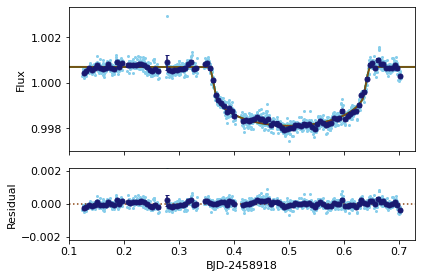

In [8]:
lmfit0 = dataset.lmfit_transit(T_0 = (T_0-0.1,T_0+0.1), P=P, 
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                      h_1=star.h_1, h_2=star.h_2.n,
                      logrhoprior=star.logrho)
dataset.plot_lmfit();

#### Fit including detrending

Include extra basis functions with Gaussian priors based on rms of previous fit.

Note that we rejected some data from the light curve so the extra basis functions (`xbf`) do not have the same time sampling, so we must provide the time sampling array of the extra basis functions in `xbf['t']`.

Adding extra decorrelation basis vector functions.
spike       : mean =    0.001, std. dev. =    0.026, min =    0.000, max =    1.000
rinf        : mean =    0.000, std. dev. =    1.452, min =   -4.795, max =    3.689
rsup        : mean =    0.000, std. dev. =    1.449, min =   -4.705, max =    4.919


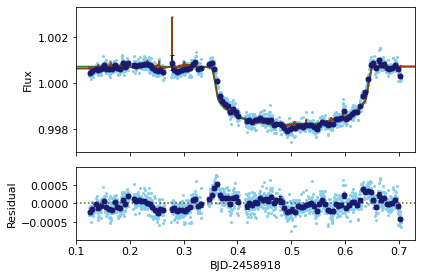

In [9]:
detrend = {}
for p in ['dfdcosphi', 'dfdsinphi', 'dfdbg', 'dfdx', 'dfdy']:
    detrend[p] = ufloat(0, lmfit0.rms)

# Extra basis functions.
spike = np.zeros_like(tdef)
spike[tdef == t_spike] = 1
xdv = {'t':tdef, 
      'spike':{'x':spike, 'init':(-1,1)}, 
      'rinf':{'x':rinf, 'init':ufloat(0, lmfit0.rms), 'label':r'$df/dR_{\rm inf}$'}, 
      'rsup':{'x':rsup, 'init':ufloat(0, lmfit0.rms), 'label':r'$df/dR_{\rm sup}$'} }

lmfit = dataset.lmfit_transit(T_0 = T_0, P=P, 
                      D=(D/4, D, D*4), W=W,b=0,
                      h_1=star.h_1.n, h_2=star.h_2.n,
                      logrhoprior=star.logrho, 
                      extra_decorr_vectors=xdv, **detrend)
dataset.plot_lmfit();

In [10]:
print(dataset.lmfit_report())


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 1498
    # variables        = 10
    chi-square         = 3032.28355
    reduced chi-square = 2.03782497
    Akaike info crit   = -20361.3125
    Bayesian info crit = -20308.1936
    RMS residual       = 229.2 ppm
[[Variables]]
    T_0:        0.5010961 (fixed)
    P:          4.736205 (fixed)
    D:          0.00207035 +/- 1.1008e-05 (0.53%) (init = 0.0022)
    W:          0.06279289 (fixed)
    b:          0 (fixed)
    f_c:        0 (fixed)
    f_s:        0 (fixed)
    l_3:        0 (fixed)
    h_1:        0.716 (fixed)
    h_2:        0.444 (fixed)
    c:          1.00071981 +/- 8.7443e-06 (0.00%) (init = 1)
    dfdbg:      2.5107e-04 +/- 4.8980e-05 (19.51%) (init = 0)
    dfdx:       3.1699e-06 +/- 4.4371e-05 (1399.78%) (init = 0)
    dfdy:       1.1711e-04 +/- 4.1570e-05 (35.50%) (init = 0)
    dfdsinphi:  5.0181e-05 +/- 8.8121e-06 (17.56%) (init = 0)
    dfdcosphi:  1.7276e-

#### Test glint_scale

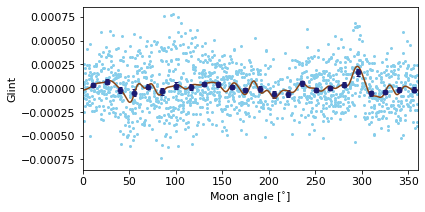

In [11]:
moon_glint = dataset.add_glint(moon=True,nspline=48,binwidth=15)

Adding extra decorrelation basis vector functions.
spike       : mean =    0.001, std. dev. =    0.026, min =    0.000, max =    1.000
rinf        : mean =    0.000, std. dev. =    1.452, min =   -4.795, max =    3.689
rsup        : mean =    0.000, std. dev. =    1.449, min =   -4.705, max =    4.919


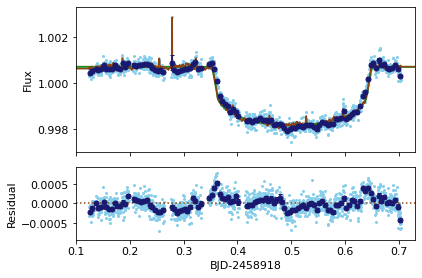

In [12]:
lmfit = dataset.lmfit_transit(T_0 = T_0, P=P, 
                      D=(D/4, D, D*4), W=W,b=0,
                      h_1=star.h_1.n, h_2=star.h_2.n,
                      logrhoprior=star.logrho, glint_scale=(-1,1),
                      extra_decorr_vectors=xdv, **detrend)
dataset.plot_lmfit();

In [13]:
print(dataset.lmfit_report())


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 1498
    # variables        = 11
    chi-square         = 2837.19908
    reduced chi-square = 1.90800207
    Akaike info crit   = -20554.3969
    Bayesian info crit = -20495.9662
    RMS residual       = 221.7 ppm
[[Variables]]
    T_0:          0.5010961 (fixed)
    P:            4.736205 (fixed)
    D:            0.00206940 +/- 1.0651e-05 (0.51%) (init = 0.0022)
    W:            0.06279289 (fixed)
    b:            0 (fixed)
    f_c:          0 (fixed)
    f_s:          0 (fixed)
    l_3:          0 (fixed)
    h_1:          0.716 (fixed)
    h_2:          0.444 (fixed)
    c:            1.00071444 +/- 8.4785e-06 (0.00%) (init = 1)
    dfdbg:        1.5451e-04 +/- 4.8435e-05 (31.35%) (init = 0)
    dfdx:         8.9075e-06 +/- 4.2924e-05 (481.89%) (init = 0)
    dfdy:         1.0434e-04 +/- 4.0236e-05 (38.56%) (init = 0)
    dfdsinphi:    5.3711e-05 +/- 8.5331e-06 (15.89%) (init 

#### Test emcee_sampler

In [14]:
emcee = dataset.emcee_sampler(add_shoterm=True, 
                              log_S0=ufloat(-23.5, 0.6), 
                              log_omega0=ufloat(5.6,0.3), 
                              log_sigma=ufloat(-10,2) )


Running burn-in ..


100%|██████████| 256/256 [02:33<00:00,  1.67it/s]

Running sampler ..



100%|██████████| 128/128 [01:04<00:00,  2.00it/s]


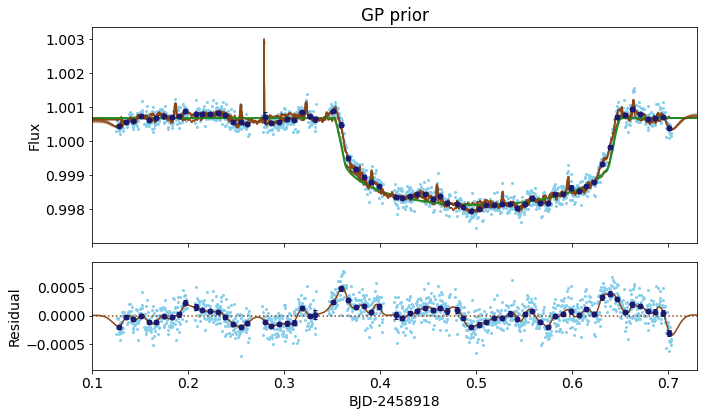

In [15]:
fig  = dataset.plot_emcee(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=False,
                          title='GP prior')

In [16]:
print(dataset.emcee_report())

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 25324
    # data points      = 1498
    # variables        = 14
    chi-square         = 2927.29195
    reduced chi-square = 1.97256870
    Akaike info crit   = -21597.9592
    Bayesian info crit = -21523.5928
    RMS residual       = 222.9 ppm
[[Variables]]
    T_0:          0.5010961 (fixed)
    P:            4.736205 (fixed)
    D:            0.00205663 +/- 4.5808e-05 (2.23%) (init = 0.0022)
    W:            0.06279289 (fixed)
    b:            0 (fixed)
    f_c:          0 (fixed)
    f_s:          0 (fixed)
    l_3:          0 (fixed)
    h_1:          0.716 (fixed)
    h_2:          0.444 (fixed)
    c:            1.00070067 +/- 3.2312e-05 (0.00%) (init = 1)
    dfdbg:        2.4582e-04 +/- 3.9018e-05 (15.87%) (init = 0)
    dfdx:         4.2300e-06 +/- 3.0015e-05 (709.56%) (init = 0)
    dfdy:         7.8955e-05 +/- 3.0107e-05 (38.13%) (init = 0)
    dfdsinphi:    4.0109e-05 +/- 3.4980e-05 (87.21%) (init

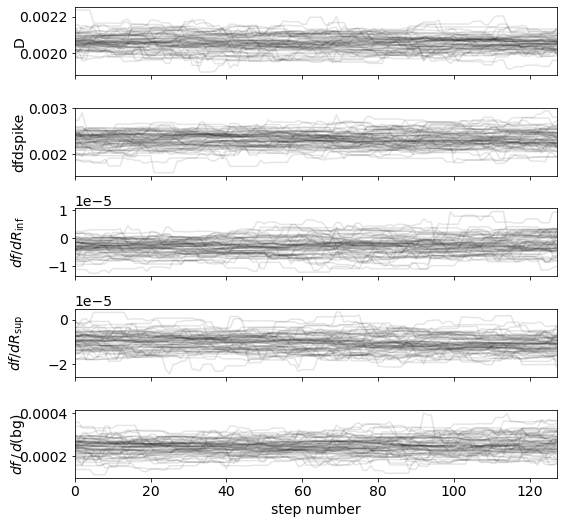

In [17]:
dataset.trail_plot(plotkeys=['D', 'dfdspike', 'dfdrinf', 'dfdrsup','dfdbg']);

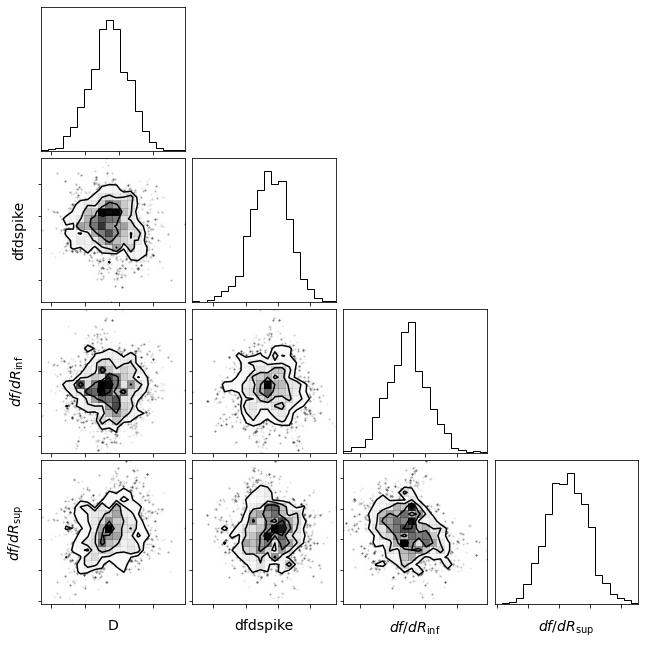

In [18]:
dataset.corner_plot(plotkeys=['D','dfdspike', 'dfdrinf','dfdrsup']);

## WASP-189

To test implementation of `extra_decorr_vectors` in Multivisit. 

Use the same test as before with an injected "spike" in each data set.

In [19]:
# Transit paramaters from  Lendl et al., 2020
BJD_0 = 2458926.541696  
P = 2.7240330
b = 0.478
k = ufloat(0.07045, 0.00014)
D = k**2

W = 4.336/24/P
from pycheops.funcs import delta_t_sec
a_c = delta_t_sec(P, M=1.9)/86400
print(f'Light travel time correction = {a_c*86400:0.1f} s')

Light travel time correction = 47.2 s


#### Load datasets into a list

In [20]:
file_keys = [f'CH_PR100041_TG00020{i}_V0200' for i in range(1,5)]
Datasets = []
t_spikes = []
for i,file_key in enumerate(file_keys):
    d = Dataset(file_key,verbose=False, metadata=True)
    Datasets.append(d)
    _ = d.get_lightcurve('DEFAULT',verbose=False,decontaminate=False)
    t_,f_,e_ = d.clip_outliers(verbose=False)
    t_mid =  d.bjd_ref+np.median(t_)
    print(f'{file_key}, n_obs={len(t_)}, BJD_REF = {d.bjd_ref}')
    i_spike = (i+1)*len(t_)//6
    t_spikes.append(d.lc['time'][i_spike])
    d.lc['flux'][i_spike] += 0.0005 + 0.0005*(i)


CH_PR100041_TG000201_V0200, n_obs=736, BJD_REF = 2458927
CH_PR100041_TG000202_V0200, n_obs=793, BJD_REF = 2458935
CH_PR100041_TG000203_V0200, n_obs=814, BJD_REF = 2458938
CH_PR100041_TG000204_V0200, n_obs=934, BJD_REF = 2458946


#### Extra decorrelation vectors

For `extra_decorr_vectors`, use line-of-sight angle to Moon from the data set meta data. 

The meta data does not contain the BJD_TDB time of observation, so interpolate onto same time system as the observed light curve via `MJD_TIME` array common to both the light curve data and the meta data.

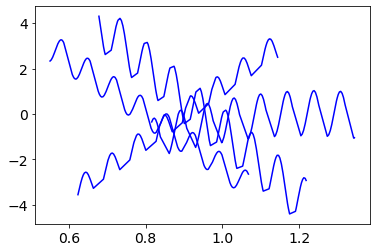

In [21]:
from scipy.interpolate import interp1d
xdvs = []
for d,t_spike in zip(Datasets, t_spikes):
    tint = interp1d(d.lc['table']['MJD_TIME'],d.lc['table']['BJD_TIME']-d.bjd_ref)
    t = tint(d.metadata['MJD_TIME'])
    extra_decorr_vectors = {'t':t}
    spike = np.zeros_like(t)
    spike[t == t_spike] = 1
    extra_decorr_vectors['spike'] = {'x':spike, 'init':(-1,1)}
    moon_angle = d.metadata['LOS_TO_MOON_ANGLE']
    moon_angle -= moon_angle.mean()
    plot(t, moon_angle, c='b')
    extra_decorr_vectors['moon_angle'] = {'x':moon_angle,
                                       'init':(-0.01, 0.01), 
                                       'label':r'$df/d\theta_{\rm Moon}$'}
    xdvs.append(extra_decorr_vectors)
    


#### Fit with decorrelation

Selection of decorrelation parameters and other details of these fits are quite arbitary here. In reality, a much more careful analysis similar to the one shown in KELT11b-tutorial would be needed.

These decorrelation parameters selected and saved in the last fit to each the individual datasets are used in Multivisit.  

Note use of the `tag` keyword in `dataset.save()` so that we can distinguish these saved datasets from datasets saved from the other notebook for  WASP-189. 


Adding extra decorrelation basis vector functions.
spike       : mean =    0.001, std. dev. =    0.036, min =    0.000, max =    1.000
moon_angle  : mean =   -0.000, std. dev. =    2.013, min =   -3.555, max =    3.306
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 736
    # variables        = 10
    chi-square         = 910.389940
    reduced chi-square = 1.25398063
    Akaike info crit   = -11526.5209
    Bayesian info crit = -11480.5086
    RMS residual       = 93.8 ppm
[[Variables]]
    T_0:           -0.458304 (fixed)
    P:              2.724033 (fixed)
    D:              0.00496294 +/- 2.2073e-05 (0.44%) (init = 0.004963202)
    W:              0.06632323 (fixed)
    b:              0.478 (fixed)
    L:              1.4425e-04 +/- 8.4282e-06 (5.84%) (init = 0.0002)
    f_c:            0 (fixed)
    f_s:            0 (fixed)
    l_3:            0 (fixed)
    c:              0.99999968 +/- 1.7727e-05 (0.00%) (init = 1)
   

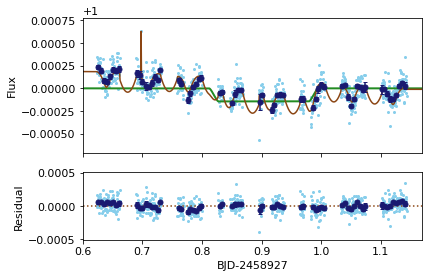

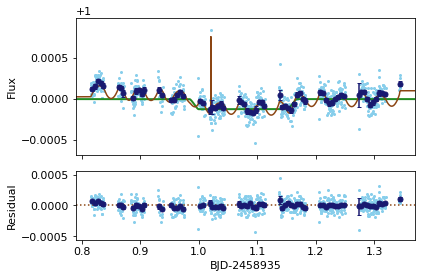

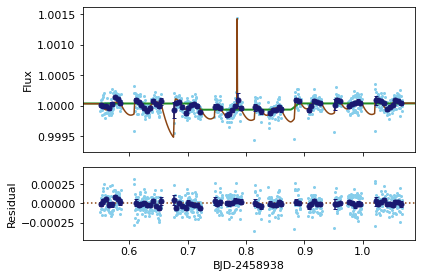

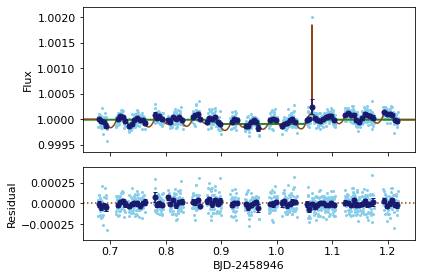

In [22]:
lmfits = []
for d,xdv in zip(Datasets, xdvs):
    T_0 = floor((d.bjd_ref-BJD_0)/P)*P + BJD_0 - d.bjd_ref
    d.lmfit_eclipse(T_0 = T_0,
                P = P, 
                L=(1e-6,2e-4,1e-3),
                W =W, D=D, b=b,
                dfdbg=(-1,1), 
                dfdsinphi=(-1,1),dfdcosphi=(-1,1),
                dfdsin2phi=(-1,1),dfdcos2phi=(-1,1),
                extra_decorr_vectors = xdv)
    print(d.lmfit_report(min_correl=0.9))
    d.plot_lmfit()
    lmfits.append(d.lmfit)
    d.save(tag='moon')  # Saves the results as a .dataset file for use in Multivisit 

In [23]:
M = MultiVisit('WASP-189',tag='moon')

Identifier : WASP-189
Coordinates: 15:02:44.87 -03:01:53.0
T_eff :  8000 +/-  99 K   [DACE]
log g :  3.90 +/- 0.09    [DACE]
[M/H] : +0.29 +/- 0.09    [DACE]
log rho : -0.89 +/- 0.16  (solar units)
h_1 : 0.787 +/- 0.100     [ATLAS]
h_2 : 0.529 +/- 0.100     [ATLAS]


 N  file_key                   Aperture last_ GP Glint Scale pipe_ver extra
 --------------------------------------------------------------------------
  1 CH_PR100041_TG000201_V0200 DEFAULT  lmfit No  No    True   13.1.0     2
  2 CH_PR100041_TG000202_V0200 DEFAULT  lmfit No  No    True   13.1.0     2
  3 CH_PR100041_TG000203_V0200 DEFAULT  lmfit No  No    True   13.1.0     2
  4 CH_PR100041_TG000204_V0200 DEFAULT  lmfit No  No    True   13.1.0     2


In [24]:
T_0 = M.tzero(BJD_0, P)
result = M.fit_eclipse(T_0=T_0, P=P, D=D, W=W, b=b, a_c=a_c, 
                    L = (0,1e-3), nroll=2,
                    log_sigma_w=ufloat(-10,5), nwalkers=128)

Running burn-in ..


100%|██████████| 256/256 [02:27<00:00,  1.74it/s]

Running sampler ..



100%|██████████| 128/128 [01:14<00:00,  1.71it/s]


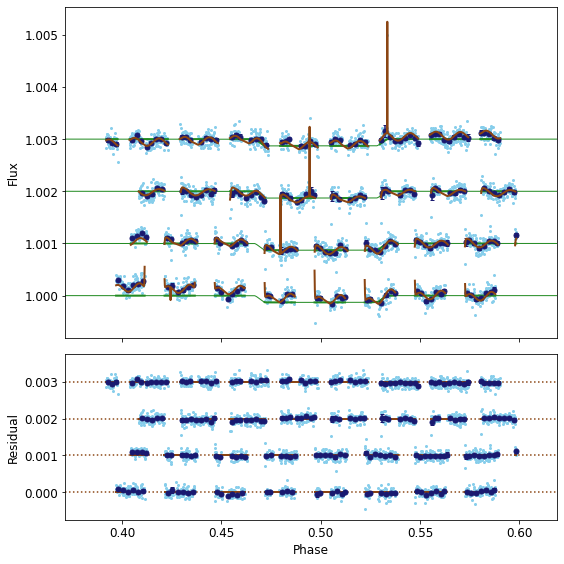

In [25]:
M.plot_fit(binwidth=0.0025, data_offset=0.001, res_offset=0.001);

In [26]:
print(M.fit_report(min_correl=0.8))

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 43205
    # data points      = 3277
    # variables        = 19
    chi-square         = 4538.18088
    reduced chi-square = 1.39293458
    Akaike info crit   = -50816.8455
    Bayesian info crit = -50701.0465
    RMS residual       = 99.6 ppm
[[Variables]]
    D:                 0.00492790 +/- 3.3946e-05 (0.69%) (init = 0.004963202)
    W:                 0.06632323 (fixed)
    b:                 0.478 (fixed)
    P:                 2.724033 (fixed)
    T_0:               1937.438 (fixed)
    f_c:               0 (fixed)
    f_s:               0 (fixed)
    l_3:               0 (fixed)
    L:                 1.3271e-04 +/- 7.8374e-06 (5.91%) (init = 0.0005)
    a_c:               0.0005461117 (fixed)
    k:                 0.07019899 == 'sqrt(D)'
    aR:                4.59548846 == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:              0.99457572 == 'sqrt(1 - (b/aR)**2)'
    logrho:           -0.75574300 == 'log10(

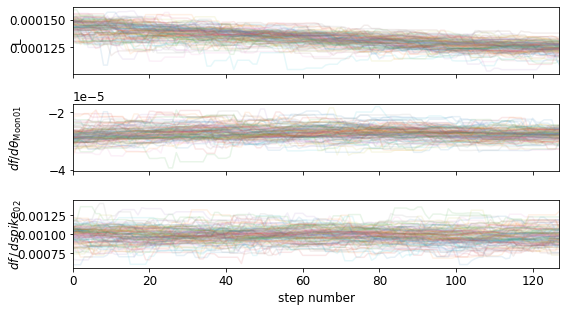

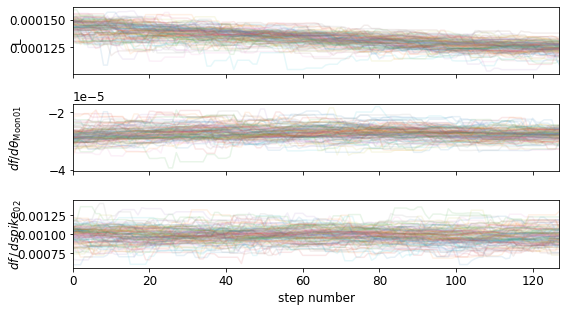

In [27]:
M.trail_plot(plotkeys=['L','dfdmoon_angle_01','dfdspike_02'])

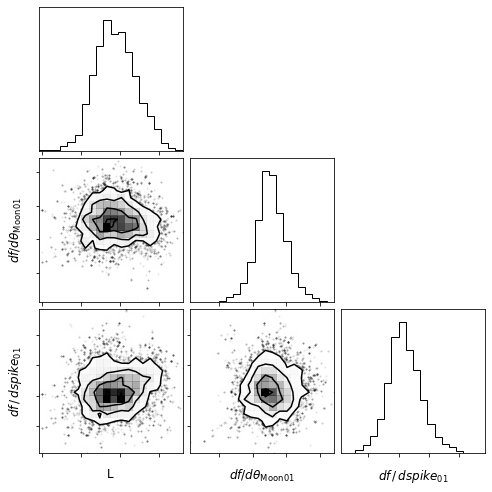

In [28]:
M.corner_plot(plotkeys=['L','dfdmoon_angle_01','dfdspike_01']);

&copy; Dr Pierre Maxted, Keele university, 2023.